# [Hw04] Feature Extraction
Jeong Ji Hoon 2016010980

### Import packages
cf. sklearn은 아래의 함수를 위해서만 사용했습니다.
- accuracy_score : performance checking
- StandardScaler : standardization
- SVC : SVM

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

### Constants

In [5]:
NUM_FEATURE = 4 # Number of Features in each sample

## 0. Load the Iris dataset using Pandas

In [6]:
#Dataset Download
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',header=None)
dataset = df.values

#Iris name to integer codes
iris_names = np.unique(dataset[:,NUM_FEATURE])
for i,name in enumerate(iris_names):
    dataset[np.where(dataset[:,NUM_FEATURE] == name),NUM_FEATURE] = i

X = dataset[:,:NUM_FEATURE].astype(float)
y = dataset[:,NUM_FEATURE].astype(int)

featureLabels = ['sepal length', 'sepal width', 'petal length', 'petal width']

print('[System] Data import success')

[System] Data import success


## 1. Spliting Data into Train/Test Sets + Standardization

In [7]:
# 데이터 나누기
def train_test_split(X, y, test_size=0.2):
    rng = np.random.RandomState(None)
    unique = np.unique(y)
    numClass = len(unique)
    numSamplePerClass = [np.sum(y==c) for c in unique]

    X_train, X_test = np.empty((0,X.shape[1])), np.empty((0,X.shape[1]))
    y_train, y_test = np.array([]), np.array([])

    for c in range(numClass):
        indexset = np.array([i for i, x in enumerate(y == unique[c]) if x])
        numTestset = int(np.round(numSamplePerClass[c] * test_size))
        index_test = indexset[np.random.permutation(numSamplePerClass[c])[:numTestset]]
        index_train = indexset[np.random.permutation(numSamplePerClass[c])[numTestset::]]
        X_test = np.append(X_test,X[index_test,:],axis=0)
        X_train = np.append(X_train,X[index_train,:],axis=0)
        y_test = np.append(y_test,y[index_test],axis=0)
        y_train = np.append(y_train,y[index_train],axis=0)

    return X_train, X_test, np.int32(y_train), np.int32(y_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 4개의 feature가 관여되기에 전부 Standardization을 진행
# Standardization
clf_std = StandardScaler()
clf_std.fit(X_train)
X_train_std = clf_std.transform(X_train)
X_test_std = clf_std.transform(X_test)

## 2. Apply Feature Extraction Methods
### 2-1. PCA


 Eigenvalues 
[2.93538759 0.92381767 0.15124377 0.02316442]


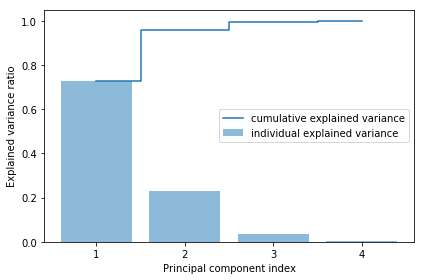

In [9]:
## Covariance 구하기

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\n Eigenvalues \n%s' %eigen_vals)


## eigen vector의 설명력 구하기.
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 5), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 5), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xticks(range(1,5))
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

- PC1만 사용해도 전체 variance의 70% 이상을 설명할 수 있다.

In [10]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)



w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis],
               eigen_pairs[2][1][:, np.newaxis],
               eigen_pairs[3][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.51522939 -0.40526533 -0.70817351  0.2622765 ]
 [-0.27931254 -0.91184175  0.26782887 -0.13710153]
 [ 0.58087032 -0.01749703  0.13542703 -0.80246062]
 [ 0.56490075 -0.06323362  0.6390755   0.51814203]]


In [11]:
## k feature에 맞게 다르게 나눈 eigen pair를 넣어둘 것.
# HW에서는 training set을 그대로 두고 사용할 feature index만 주면 되었는데 여기서는 X를 변환시켜주어야 함.


newX_train_PCA = []
newX_test_PCA = []

for i in range(4): # k=1부터 4까지 해서
    newX_train_PCA.append(X_train_std.dot(w[:,0:i+1]))
    newX_test_PCA.append(X_test_std.dot(w[:,0:i+1]))

## 2-2. LDA

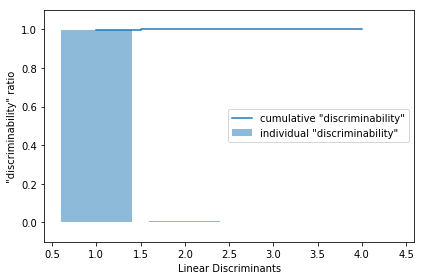

In [12]:
# Caluate Mean Vectors
mean_vecs = []
for c in range(3):
    mean_vecs.append(np.mean(X_train_std[y_train == c], axis = 0))

# Within-class scatter matrix(scaled) = covariance matrix 구하기
S_W = np.zeros((NUM_FEATURE, NUM_FEATURE))
for label, mv in zip(range(3), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

# Between-class scatter matrix 구하기
S_B = np.zeros((NUM_FEATURE, NUM_FEATURE))
mean_overall = np.mean(X_train_std, axis=0)
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(NUM_FEATURE, 1)  # make column vector
    mean_overall = mean_overall.reshape(NUM_FEATURE, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

# eigen pair 구하기
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# eigen pair 정렬
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)


# 도식화
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 5), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 5), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()

- class label을 제공해서 LDA를 돌리니 PC1 만으로도 거의 100%의 variance를 설명할 수 있었다. 

In [13]:
# projection matrix 만들기
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real,
               eigen_pairs[2][1][:, np.newaxis].real,
               eigen_pairs[3][1][:, np.newaxis].real))


## k feature에 맞게 dataset을 정하기.
newX_train_LDA = []
newX_test_LDA = []

for i in range(4): # k=1부터 4까지 해서
    newX_train_LDA.append(X_train_std.dot(w[:,0:i+1]))
    newX_test_LDA.append(X_test_std.dot(w[:,0:i+1]))

## 2-3. kernel PCA

In [14]:
# 책에 나온 코드 그대로.

from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh


def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]

    gamma: float
      Tuning parameter of the RBF kernel

    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
       Projected dataset

     lambdas: list
       Eigenvalues

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:, i]
                              for i in range(n_components)))

    # Collect the corresponding eigenvalues
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

In [33]:
## k feature에 맞게 dataset을 정하기.
newX_train_kPCA = []
newX_test_kPCA = []

for i in range(4): # k=1부터 4까지 해서
    alphas, lambdas = rbf_kernel_pca(X_train_std, gamma=15, n_components=i+1)
    newX_train_kPCA.append(alphas)
    testDat = np.empty((0,i+1))
    for s in range(X_test_std.shape[0]):
        testDat = np.append(testDat,project_x(X_test_std[s,:],X_train_std, gamma=15, alphas=alphas, lambdas=lambdas).reshape(1,-1),axis=0)
    newX_test_kPCA.append(testDat)

## 3. Classification using Logistic Regression & SVM

### 3-1. Define Classifier

In [34]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.

    """

    def __init__(self, eta=0.05, n_iter=100, random_state=1, batch_size=-1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.batch_size = batch_size

    def fit(self, X, y):
        """ Fit training data.
        batch size를 기준으로 입력된 X 값을 batch size로 나눠서 학습을 시킴.
        X 사이즈가 batch size로 딱 나누어 떨어지지 않는 경우,
         맨 마지막 남는 데이터는 batch size 보다 크기가 작아도 그대로 학습을 진행.
         ex) X.shape[0] = 150, batch_size = 100
         epoch1-1 : X[0:100]
         epoch1-2 : X[100:150]
         epoch2-1 : X[0:100]
         epoch2-2 : X[100:150]
       대신 batch size로 -1을 넣는 경우 그냥 batch Gradient Descent 방식을 사용.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        if self.batch_size == -1:  # Batch Gradient
            self.batch_size = X.shape[0]
        for i in range(self.n_iter):
            if X.shape[0] % self.batch_size == 0:  # training set 크기가 batch_size로 딱 나눠지는 경우
                batch_n_iter = int(X.shape[0] / self.batch_size)  # batch를 돌려아 하는 횟수.
                # 딱 나눠지는 경우에는 배치 사이즈 그대로 train을 시킴.
                for b in range(batch_n_iter):
                    smallX = X[self.batch_size * b: self.batch_size * (b + 1), :]
                    smally = y[self.batch_size * b: self.batch_size * (b + 1)]
                    net_input = self.net_input(smallX)
                    output = self.activation(net_input)
                    errors = (smally - output)
                    self.w_[1:] += self.eta * smallX.T.dot(errors)
                    self.w_[0] += self.eta * errors.sum()
                    cost = -smally.dot(np.log(output)) - ((1 - smally).dot(np.log(1 - output)))
                    self.cost_.append(cost)

            else:  # training set 크기가 batchsize로 딱 나눠지지 않는 경우
                batch_n_iter = int(np.floor(X.shape[0] / self.batch_size))
                # 배치 사이즈 그대로 train을 시키고,
                for b in range(batch_n_iter):
                    smallX = X[self.batch_size * b: self.batch_size * (b + 1), :]
                    smally = y[self.batch_size * b: self.batch_size * (b + 1)]
                    net_input = self.net_input(smallX)
                    output = self.activation(net_input)
                    errors = (smally - output)
                    self.w_[1:] += self.eta * smallX.T.dot(errors)
                    self.w_[0] += self.eta * errors.sum()
                    cost = -smally.dot(np.log(output)) - ((1 - smally).dot(np.log(1 - output)))
                    self.cost_.append(cost)
                # 나머지를 전부 넣어줌.
                smallX = X[self.batch_size * batch_n_iter:, :]
                smally = y[self.batch_size * batch_n_iter:]
                net_input = self.net_input(smallX)
                output = self.activation(net_input)
                errors = (smally - output)
                self.w_[1:] += self.eta * smallX.T.dot(errors)
                self.w_[0] += self.eta * errors.sum()
                cost = -smally.dot(np.log(output)) - ((1 - smally).dot(np.log(1 - output)))
                self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


class LogisticRegressionGD_3C(object):
    """Class 3개인 데이터를 위한 classifier.
    3개의 LogisticRegressionGD Class를 만든뒤 One Versus All 방식으로 Class를 분류."""

    def __init__(self, eta=0.001, n_iter=1000, random_state=1, batch_size=-1):
        self.clf = [LogisticRegressionGD(eta=eta, n_iter=n_iter, random_state=random_state, batch_size=batch_size),
                    LogisticRegressionGD(eta=eta, n_iter=n_iter, random_state=random_state, batch_size=batch_size),
                    LogisticRegressionGD(eta=eta, n_iter=n_iter, random_state=random_state, batch_size=batch_size)]

    def fit(self, X, y):
        # y값이 -1과 1이 아니라 0,1,2 의 세 숫자로 구성되기에 각 classifier에 맞는 형태로 변형시켜주어야 함.
        y_3C = 0 * np.ones([y.size, 3])  # sample 수 X 3 크기로 전부 0인 array를 만들고,
        for s, c in enumerate(y):  # 모든 sample에 대해서
            y_3C[s, c] = 1  # index y에 해당하는 값만 1로 바꿔줌.
            # 이렇게 하면 Class0인 경우 [1,-1,-1], Class1인 경우 [-1,1,-1] 형태의 array가 만들어짐.

        for c in range(3):
            self.clf[c].fit(X, y_3C[:, c])
        return self

    def predict(self, X):
        result = np.zeros([X.shape[0], 3])
        for c in range(3):
            result[:, c] = self.clf[c].net_input(X)  # predict를 바로 하는 것이 아니라 net_input 값만 받아둠.
        return np.argmax(result, axis=1)

### 3-2. Show Result

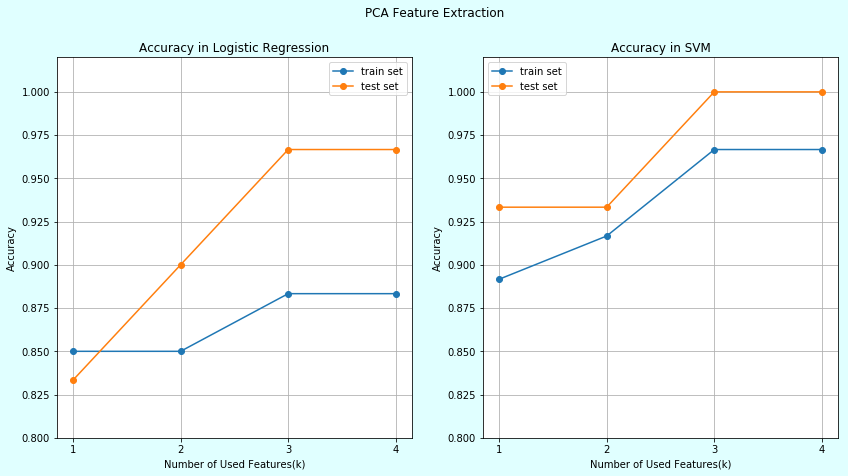

In [35]:
# Performance
result_train_log = []
result_test_log = []

eta = 0.01
batch_size = 4

for f in range(4):
    clf = LogisticRegressionGD_3C(random_state=1, eta=eta, n_iter=50, batch_size=batch_size)
    clf.fit(newX_train_PCA[f],y_train)
    result_train_log.append(accuracy_score(y_train,clf.predict(newX_train_PCA[f])))
    result_test_log.append(accuracy_score(y_test, clf.predict(newX_test_PCA[f])))


# 교수님께서 classifier 는 sklearn을 쓸 수 있도록 하셨으리라 믿고
from sklearn.svm import SVC
result_train_svm = []
result_test_svm = []

for f in range(4):
    svm = SVC(kernel='rbf', C=1.0, random_state=1)
    svm.fit(newX_train_PCA[f],y_train)
    result_train_svm.append(accuracy_score(y_train,svm.predict(newX_train_PCA[f])))
    result_test_svm.append(accuracy_score(y_test, svm.predict(newX_test_PCA[f])))


fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('PCA Feature Extraction')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy in Logistic Regression')
ax[0].plot(np.array(range(4))+1, np.vstack((result_train_log, result_test_log)).T, marker='o')
ax[0].set_ylim(0.8, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Number of Used Features(k)')
ax[0].set_xticks(np.array(range(4))+1)
ax[0].grid()
ax[0].legend(['train set','test set'])

ax[1].set_title('Accuracy in SVM')
ax[1].plot(np.array(range(4))+1, np.vstack((result_train_svm, result_test_svm)).T, marker='o')
ax[1].set_ylim(0.8, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of Used Features(k)')
ax[1].set_xticks(np.array(range(4))+1)
ax[1].grid()
ax[1].legend(['train set','test set'])

#### PCA 결과
- 당연하게도 k 값이 증가할 수록 (사용한 PC가 증가할 수록) 정확도가 올라가는 결과가 도출되었다.
- Logistic Regression 보다는 SVM에서 전반적으로 결과가 좋게 나왔다.

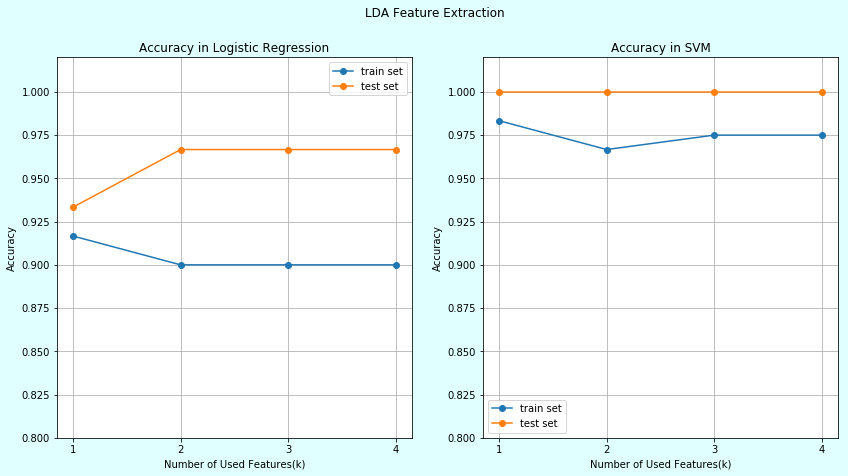

In [36]:
# Performance
result_train_log = []
result_test_log = []

eta = 0.01
batch_size = 4

for f in range(4):
    clf = LogisticRegressionGD_3C(random_state=1, eta=eta, n_iter=50, batch_size=batch_size)
    clf.fit(newX_train_LDA[f],y_train)
    result_train_log.append(accuracy_score(y_train,clf.predict(newX_train_LDA[f])))
    result_test_log.append(accuracy_score(y_test, clf.predict(newX_test_LDA[f])))


# 교수님께서 classifier 는 sklearn을 쓸 수 있도록 하셨으리라 믿고
from sklearn.svm import SVC
result_train_svm = []
result_test_svm = []

for f in range(4):
    svm = SVC(kernel='rbf', C=1.0, random_state=1)
    svm.fit(newX_train_LDA[f],y_train)
    result_train_svm.append(accuracy_score(y_train,svm.predict(newX_train_LDA[f])))
    result_test_svm.append(accuracy_score(y_test, svm.predict(newX_test_LDA[f])))


fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('LDA Feature Extraction')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy in Logistic Regression')
ax[0].plot(np.array(range(4))+1, np.vstack((result_train_log, result_test_log)).T, marker='o')
ax[0].set_ylim(0.8, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Number of Used Features(k)')
ax[0].set_xticks(np.array(range(4))+1)
ax[0].grid()
ax[0].legend(['train set','test set'])

ax[1].set_title('Accuracy in SVM')
ax[1].plot(np.array(range(4))+1, np.vstack((result_train_svm, result_test_svm)).T, marker='o')
ax[1].set_ylim(0.8, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of Used Features(k)')
ax[1].set_xticks(np.array(range(4))+1)
ax[1].grid()
ax[1].legend(['train set','test set'])

#### LDA 결과
- PCA와 가장 큰 차이점이 class label을 같이 주는 것인 LDA의 경우 feature extraction에 사용한 정보의 양이 많아서 인지 PCA보다 두 classifier 모두에서 적은 feature 수로도 좋은 결과가 도출되었다.
- 이는 위 explained variance 그래프에서 LDA k=1 인 경우에도 90% 이상의 variance를 설명했다는 결과과 어느정도 일치한다.

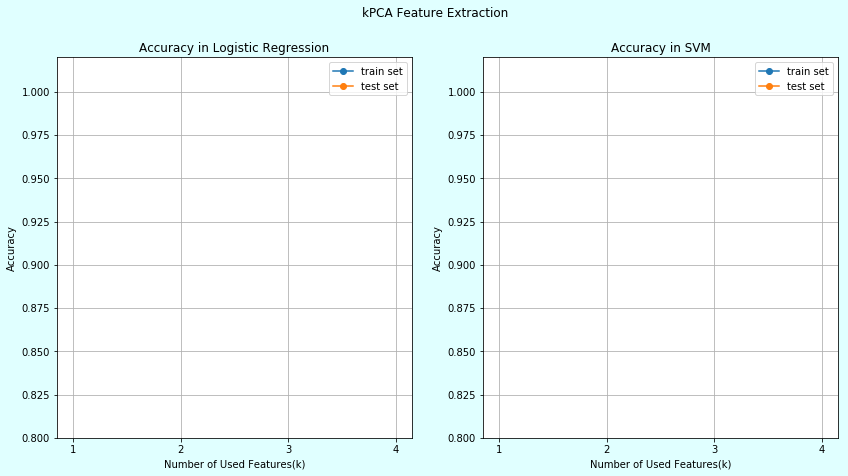

In [38]:
# Performance
result_train_log = []
result_test_log = []

eta = 0.01
batch_size = 4

for f in range(4):
    clf = LogisticRegressionGD_3C(random_state=1, eta=eta, n_iter=50, batch_size=batch_size)
    clf.fit(newX_train_kPCA[f],y_train)
    result_train_log.append(accuracy_score(y_train,clf.predict(newX_train_kPCA[f])))
    result_test_log.append(accuracy_score(y_test, clf.predict(newX_test_kPCA[f])))


# 교수님께서 classifier 는 sklearn을 쓸 수 있도록 하셨으리라 믿고
from sklearn.svm import SVC
result_train_svm = []
result_test_svm = []

for f in range(4):
    svm = SVC(kernel='rbf', C=1.0, random_state=1)
    svm.fit(newX_train_kPCA[f],y_train)
    result_train_svm.append(accuracy_score(y_train,svm.predict(newX_train_kPCA[f])))
    result_test_svm.append(accuracy_score(y_test, svm.predict(newX_test_kPCA[f])))


fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('kPCA Feature Extraction')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy in Logistic Regression')
ax[0].plot(np.array(range(4))+1, np.vstack((result_train_log, result_test_log)).T, marker='o')
ax[0].set_ylim(0.8, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Number of Used Features(k)')
ax[0].set_xticks(np.array(range(4))+1)
ax[0].grid()
ax[0].legend(['train set','test set'])

ax[1].set_title('Accuracy in SVM')
ax[1].plot(np.array(range(4))+1, np.vstack((result_train_svm, result_test_svm)).T, marker='o')
ax[1].set_ylim(0.8, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of Used Features(k)')
ax[1].set_xticks(np.array(range(4))+1)
ax[1].grid()
ax[1].legend(['train set','test set'])

- ??? 그래프가 없다.

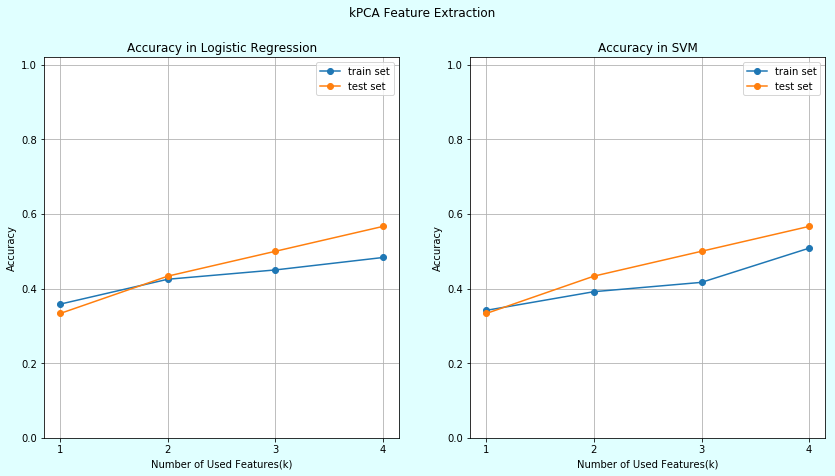

In [39]:
fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('kPCA Feature Extraction')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy in Logistic Regression')
ax[0].plot(np.array(range(4))+1, np.vstack((result_train_log, result_test_log)).T, marker='o')
ax[0].set_ylim(0, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Number of Used Features(k)')
ax[0].set_xticks(np.array(range(4))+1)
ax[0].grid()
ax[0].legend(['train set','test set'])

ax[1].set_title('Accuracy in SVM')
ax[1].plot(np.array(range(4))+1, np.vstack((result_train_svm, result_test_svm)).T, marker='o')
ax[1].set_ylim(0, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of Used Features(k)')
ax[1].set_xticks(np.array(range(4))+1)
ax[1].grid()
ax[1].legend(['train set','test set'])

- 머리를 부여잡다가 y축을 바꾸니 저 밑에 보인다. 
- 0.33 이 chance level로 맞출 확률임을 생각해보면 엄청 낮은 performance다.
- kPCA와 유일하게 다른 점은 rbf kernel을 썼다는 것인데 여기에는 gamma 값이 hyperparameter로 들어간다.
- 이 값 때문에 문제가 생기는 것이 아닐까 하고 값을 적당하 바꾸어 봤다.

In [52]:
## k feature에 맞게 dataset을 정하기.
newX_train_kPCA = []
newX_test_kPCA = []

for i in range(4): # k=1부터 4까지 해서
    alphas, lambdas = rbf_kernel_pca(X_train_std, gamma=0.3, n_components=i+1)
    newX_train_kPCA.append(alphas)
    testDat = np.empty((0,i+1))
    for s in range(X_test_std.shape[0]):
        testDat = np.append(testDat,project_x(X_test_std[s,:],X_train_std, gamma=0.3, alphas=alphas, lambdas=lambdas).reshape(1,-1),axis=0)
    newX_test_kPCA.append(testDat)

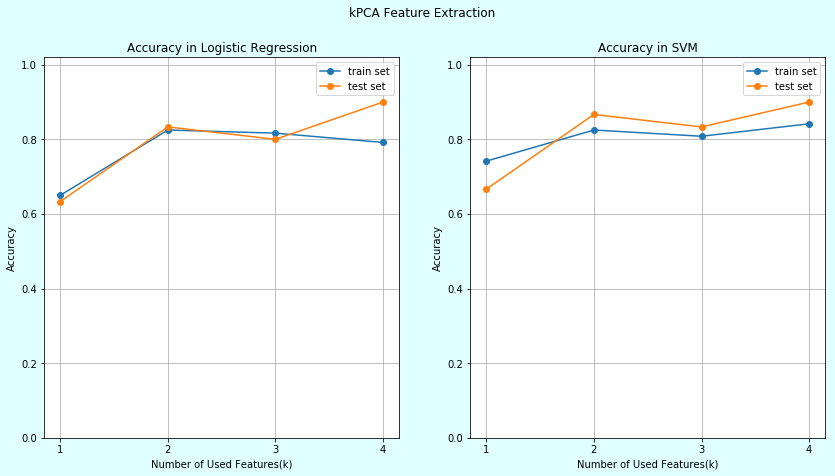

In [53]:
# Performance
result_train_log = []
result_test_log = []

eta = 0.01
batch_size = 4

for f in range(4):
    clf = LogisticRegressionGD_3C(random_state=1, eta=eta, n_iter=50, batch_size=batch_size)
    clf.fit(newX_train_kPCA[f],y_train)
    result_train_log.append(accuracy_score(y_train,clf.predict(newX_train_kPCA[f])))
    result_test_log.append(accuracy_score(y_test, clf.predict(newX_test_kPCA[f])))


# 교수님께서 classifier 는 sklearn을 쓸 수 있도록 하셨으리라 믿고
from sklearn.svm import SVC
result_train_svm = []
result_test_svm = []

for f in range(4):
    svm = SVC(kernel='rbf', C=1.0, random_state=1)
    svm.fit(newX_train_kPCA[f],y_train)
    result_train_svm.append(accuracy_score(y_train,svm.predict(newX_train_kPCA[f])))
    result_test_svm.append(accuracy_score(y_test, svm.predict(newX_test_kPCA[f])))


fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('kPCA Feature Extraction')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy in Logistic Regression')
ax[0].plot(np.array(range(4))+1, np.vstack((result_train_log, result_test_log)).T, marker='o')
ax[0].set_ylim(0, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Number of Used Features(k)')
ax[0].set_xticks(np.array(range(4))+1)
ax[0].grid()
ax[0].legend(['train set','test set'])

ax[1].set_title('Accuracy in SVM')
ax[1].plot(np.array(range(4))+1, np.vstack((result_train_svm, result_test_svm)).T, marker='o')
ax[1].set_ylim(0, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of Used Features(k)')
ax[1].set_xticks(np.array(range(4))+1)
ax[1].grid()
ax[1].legend(['train set','test set'])

- gamma 값을 이리 저리 만지다 0.3 일때 그나마 납득할만한 결과가 나온다는 것을 확인하였다.

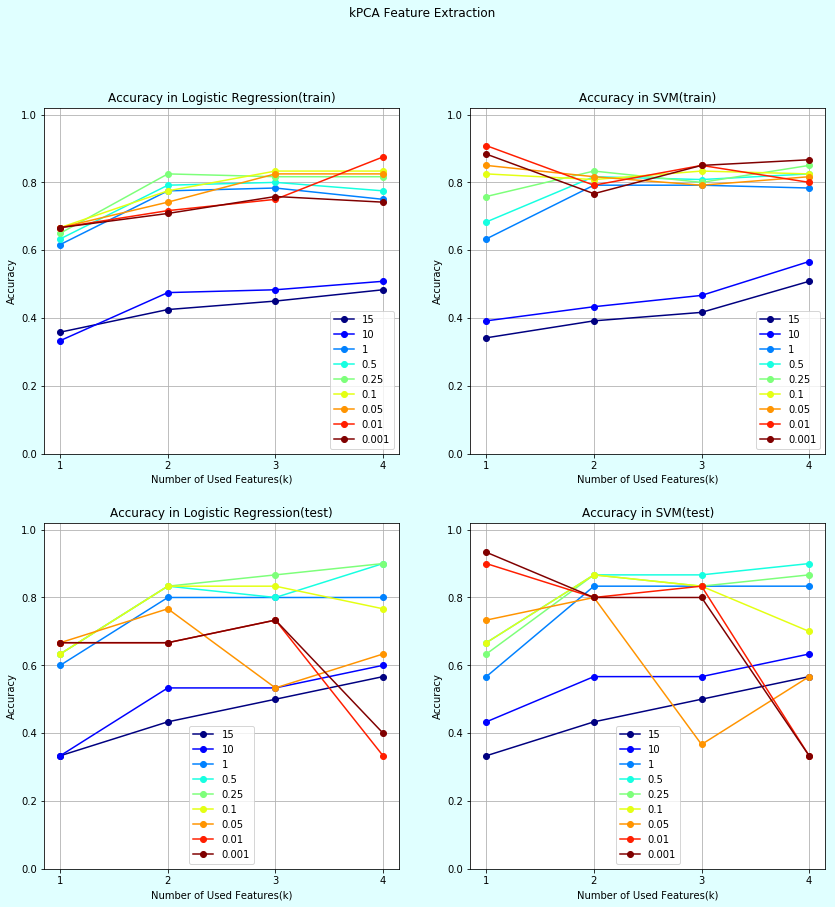

In [68]:
fig = plt.figure(figsize=(14,14))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('kPCA Feature Extraction')

ax = fig.subplots(2,2)

colors = plt.cm.jet(np.linspace(0,1,len(gammas)))

ax[0,0].set_title('Accuracy in Logistic Regression(train)')
for i in range(len(gammas)):
    ax[0,0].plot(np.array(range(4))+1, gammatrain_log[i], marker='o', color=colors[i])
ax[0,0].set_ylim(0, 1.02)
ax[0,0].set_ylabel('Accuracy')
ax[0,0].set_xlabel('Number of Used Features(k)')
ax[0,0].set_xticks(np.array(range(4))+1)
ax[0,0].grid()
ax[0,0].legend(gammas)

ax[0,1].set_title('Accuracy in SVM(train)')
for i in range(len(gammas)):
    ax[0,1].plot(np.array(range(4))+1, gammatrain_svm[i], marker='o', color=colors[i])
ax[0,1].set_ylim(0, 1.02)
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_xlabel('Number of Used Features(k)')
ax[0,1].set_xticks(np.array(range(4))+1)
ax[0,1].grid()
ax[0,1].legend(gammas)

ax[1,0].set_title('Accuracy in Logistic Regression(test)')
for i in range(len(gammas)):
    ax[1,0].plot(np.array(range(4))+1, gammatest_log[i], marker='o', color=colors[i])
ax[1,0].set_ylim(0, 1.02)
ax[1,0].set_ylabel('Accuracy')
ax[1,0].set_xlabel('Number of Used Features(k)')
ax[1,0].set_xticks(np.array(range(4))+1)
ax[1,0].grid()
ax[1,0].legend(gammas)

ax[1,1].set_title('Accuracy in SVM(test)')
for i in range(len(gammas)):
    ax[1,1].plot(np.array(range(4))+1, gammatest_svm[i], marker='o', color=colors[i])
ax[1,1].set_ylim(0, 1.02)
ax[1,1].set_ylabel('Accuracy')
ax[1,1].set_xlabel('Number of Used Features(k)')
ax[1,1].set_xticks(np.array(range(4))+1)
ax[1,1].grid()
ax[1,1].legend(gammas)

#### kPCA 결과
- kPCA는 LDA와 PCA와는 다르게 parameter gamma 값을 따로 세팅 해주어야 한다.
- 책의 wine dataset에 사용했던 15를 사용했는데 결과가 그래프에 안잡혀 따로 축 범위를 조정해주어야 했다.
- 다양한 gamma 값을 가지고 테스트 한 결과 재미있는(어찌보면 당연한) 결과가 나왔는데 너무 높은 gamma 값을 사용하면 아예 제대로 학습이 안되고 너무 낮은 gamma 값을 사용하면 train set에서만 performance가 높은(over-fitted) classifier가 나온다는 것이다.
- 적당한 gamma를 사용해야(1, 0.5, 0.25 ) trainset, testset 모두에서 80%이상의 performance를 보였다.